In [6]:
# CartPole
# Discrete Control input
# Actor Critic structure, with tensorflow
# using TD-error as advantage
# experience could be dumped

# Hope it works

import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

n_observation = 4
n_action = 2
n_hidden_c = 10
n_hidden_a = 10

# Critic Network used to estimate state value function v
tf_obs_c = tf.placeholder(tf.float32, [None, n_observation])
# layers
W1_c = tf.Variable(tf.random_normal([n_observation, n_hidden_c], stddev=0.1))
b1_c = tf.Variable(tf.random_normal([n_hidden_c]))
W2_c = tf.Variable(tf.random_normal([n_hidden_c, 1], stddev=0.1))
b2_c = tf.Variable(tf.random_normal([1]))
    
fc1_c = tf.nn.relu(tf.matmul(tf_obs_c, W1_c) + b1_c)
tf_v = tf.matmul(fc1_c, W2_c) + b2_c

# training
tf_target_v = tf.placeholder(tf.float32, [None, 1])
loss_c = tf.reduce_sum(tf.square(tf_target_v - tf_v))
trainer_c = tf.train.AdamOptimizer(0.01).minimize(loss_c)

# Actor Network
tf_obs_a = tf.placeholder(tf.float32, [None, n_observation])
tf_action = tf.placeholder(tf.int32, [None, 1])
tf_advantage = tf.placeholder(tf.float32)
# layers
W1_a = tf.Variable(tf.random_normal([n_observation, n_hidden_a], stddev=0.1))
b1_a = tf.Variable(tf.random_normal([n_hidden_a]))
W2_a = tf.Variable(tf.random_normal([n_hidden_a, n_action], stddev=0.1))
b2_a = tf.Variable(tf.random_normal([n_action]))
    
fc1_a = tf.nn.relu(tf.matmul(tf_obs_a, W1_a) + b1_a)
out_a = tf.matmul(fc1_a, W2_a) + b2_a
tf_prob = tf.nn.softmax(out_a)
tf_prob = tf.squeeze(tf_prob)
# training
tf_action_onehot = tf.squeeze(tf.one_hot(tf_action, n_action))
tf_act_prob = tf.reduce_sum(tf_prob * tf_action_onehot, 1)
tf_log_prob = tf.log(tf_act_prob)

# tf_action_onehot = tf.one_hot(tf_action, n_action)
# tf_act_prob = tf.reduce_sum(tf_prob * tf_action_onehot)
# tf_log_prob = tf.log(tf_act_prob)

# td_error, advantge as the direction
loss_a = -tf_log_prob * tf_advantage
trainer_a = tf.train.AdamOptimizer(0.001).minimize(loss_a)

# replay buffer
class experience_buffer():
    def __init__(self, buffer_size = 10000):
        self.buf = []
        self.buffer_size = buffer_size * 5
    
    def add(self, experience):
        if len(self.buf) + len(experience) >= self.buffer_size:
            self.buf[0:(len(experience) + len(self.buf))-self.buffer_size] = []
        self.buf.extend(experience)
        
    def sample(self, batch_size):
        if batch_size > len(self.buf): 
            print 'not enough experiences'
            batch_size = 1
        batch = np.reshape(np.array(random.sample(self.buf, batch_size)), [batch_size, 5])
        s_batch = np.vstack(batch[:, 0])
        a_batch = np.vstack(batch[:, 1])
        r_batch = np.vstack(batch[:, 2])
        s1_batch = np.vstack(batch[:, 3])
        d_batch = np.vstack(batch[:, 4])
        return s_batch, a_batch, r_batch, s1_batch, d_batch
    
    def dump(self):
        self.buf = []
    


[2017-07-16 17:38:03,092] Making new env: CartPole-v0


episode: 0 rsum: -6.0
episode: 100 rsum: -7.0
episode: 200 rsum: -11.0
episode: 300 rsum: 19.0
episode: 400 rsum: -8.0
episode: 500 rsum: -6.0
episode: 600 rsum: 33.0
episode: 700 rsum: -8.0
episode: 800 rsum: 1.0
episode: 900 rsum: -4.0


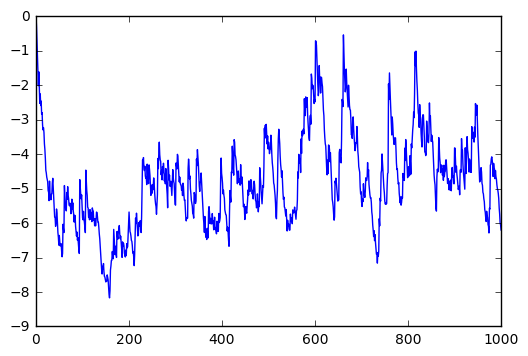

In [7]:
# Init tensorflow
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)
env = gym.make('CartPole-v0')
gamma = 0.9
batch_size = 15
pre_train_episodes = 10
loss_log = []
action_log = []
rsum_log = [0]

replay_buffer = experience_buffer()

for episode in range(1000):
    s = env.reset()
    rsum = 0
    for step in range(200):
        prob = sess.run(tf_prob, feed_dict={tf_obs_a:[s]})
        action = np.random.choice([0, 1], p=prob)
        s1, r, d, info = env.step(action)
        if d:  r = -20
        rsum += r
        # save experience
        replay_buffer.add(np.reshape(np.array([s, action, r, s1, d]),[1,5]))
        
        # Training
        if (step + 1) % 20 == 0:
            # sample experience
            s_batch, a_batch, r_batch, s1_batch, d_batch = replay_buffer.sample(batch_size)
            v1 = sess.run(tf_v, feed_dict={tf_obs_c:s1_batch})
            v = sess.run(tf_v, feed_dict={tf_obs_c:s_batch})
            end_edit = -(r_batch - 1)
            target_v = r_batch + gamma * v1 * (end_edit)

            # train critic network
            sess.run(trainer_c, feed_dict={tf_obs_c:s_batch, tf_target_v:target_v})

            # train actor network, use td error as advantage
            # no batch update
#             v1_a = sess.run(tf_v, feed_dict={tf_obs_c:[s1]})
#             v_a = sess.run(tf_v, feed_dict={tf_obs_c:[s]})
#             target_v_a = r + gamma * v1_a
#             td_error = target_v_a - v_a

#             sess.run(trainer_a, feed_dict={tf_obs_a: [s], 
#                                            tf_action: np.array([[action]]), 
#                                            tf_advantage: td_error})
            
            
            td_error = target_v - v
            _, act_prob =  sess.run([trainer_a, tf_act_prob],  feed_dict={tf_obs_a:s_batch, tf_action:a_batch, tf_advantage:td_error})
            replay_buffer.dump()
            
        s = s1
        
        if d: break
        
    # End of episode
    rsum_log.append(rsum * 0.05 + rsum_log[-1] * 0.95)
    if episode % 100 == 0:
        print 'episode:', episode, 'rsum:', rsum
plt.plot(rsum_log)
plt.show()

In [5]:
act_prob

176.46863

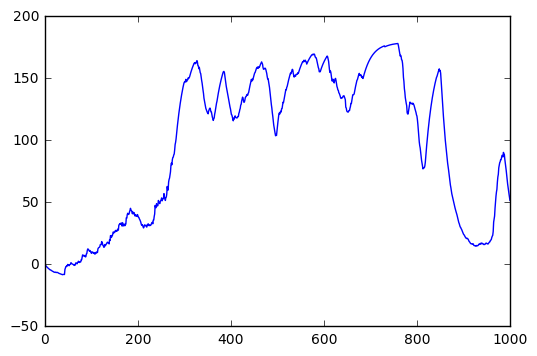

In [5]:
plt.plot(rsum_log)
plt.show()

In [ ]:
# show
for episode in range(200):
    s = env.reset()
    for step in range(200):
        prob = sess.run(tf_prob, feed_dict={tf_obs_a:[s]})[0]
        action = np.random.choice([0, 1], p=prob)
        s1, r, d, info = env.step(action)
        env.render()
        s = s1
        if d: break
        
